In [1]:
import pandas as pd
import numpy as np
import random

random.seed(42)

card_properties = ['ID', 'D', 'S', 'due', 'delta_t', 'recall', 'last_date', 't_history', 'r_history']
dtypes = np.dtype([
    ('ID', int),
    ('D', float),
    ('S', float),
    ('due', int),
    ('delta_t', int),
    ('recall', float),
    ('last_date', int),
    ('t_history', str),
    ('r_history', str),
])

init_w = [1, 1, 5, 0.5, 0.5, 0.2, 1.4, 0.2, 0.8, 2, 0.2, 0.2, 1]
deck_size = 10000


def init_stability(d):
    return max(0.5, ((d - init_w[2]) / -init_w[3] + 2) * init_w[1] + init_w[0])

df_card = pd.DataFrame(np.full(deck_size, np.nan, dtype=dtypes), index=range(deck_size), columns=card_properties)
df_card['ID'] = range(deck_size)
df_card['D'] = df_card['D'].map(lambda x: max(min(random.gauss(5.5, 2), 10), 1))
df_card['due'] = 1000
df_card.head()

,ID,D,S,due,delta_t,recall,last_date,t_history,r_history
0,0,5.211819,NaN,1000,0,NaN,0,,
1,1,5.154193,NaN,1000,0,NaN,0,,
2,2,5.277368,NaN,1000,0,NaN,0,,
3,3,6.903967,NaN,1000,0,NaN,0,,
4,4,5.244823,NaN,1000,0,NaN,0,,


In [2]:
revlog_properties = ['card_id', 'review_date', 'delta_t', 'rating', 't_history', 'r_history', 'stability', 'difficulty']
dtypes = np.dtype([
    ('card_id', int),
    ('review_date', int),
    ('delta_t', int),
    ('rating', int),
    ('t_history', str),
    ('r_history', str),
    ('stability', float),
    ('difficulty', float),
])
df_revlog = pd.DataFrame(columns=revlog_properties)

In [3]:
from tqdm import tqdm

card_per_day_limit = 100
learn_limit = 100
review_limit = 100
deck_size = 100000  # 新卡片总量
learn_days = 1000
period_len = 15
request_recall = 0.9


def scheduler(reps):
    ivl_list = [2**i for i in range(1, 10)]
    return ivl_list[min(reps, len(ivl_list) - 1)]
    #  + random.randint(1, 10)


def cal_next_recall_stability(s, r, d, response):
    if response == 1:
        return s * (1 + np.exp(init_w[6]) * (11 - d) * np.power(s, -init_w[7]) * (np.exp((1 - r) * init_w[8]) - 1))
    else:
        return init_w[9] * np.power(d, -init_w[10]) * np.power(s, init_w[11]) * np.exp((1 - r) * init_w[12])

df_card['reps'] = 0
new_card_per_day = np.array([0.0] * learn_days)

for day in tqdm(range(learn_days)):
    df_card['delta_t'] = day - df_card['last_date']
    df_card['recall'] = np.exp(np.log(0.9) * df_card["delta_t"] / df_card["S"])
    
    need_review = df_card[df_card['due'] <= day]
    for idx in need_review.sort_values('due').index[:review_limit]:
        df_card.loc[idx, 'last_date'] = day
        recall = df_card.loc[idx, 'recall']
        rating = 1 if random.random() < recall else 0
        df_card.loc[idx, 'reps'] = df_card.loc[idx, 'reps'] + 1 if rating == 1 else 0
        df_revlog = pd.concat([df_revlog, pd.DataFrame({
            'card_id': idx,
            'review_date': day,
            'delta_t': df_card.loc[idx, 'delta_t'],
            'rating': rating,
            't_history': df_card.loc[idx, 't_history'],
            'r_history': df_card.loc[idx, 'r_history'],
            'stability': df_card.loc[idx, 'S'],
            'difficulty': df_card.loc[idx, 'D'],
        }, index=[0])], ignore_index=True)
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 't_history'] += f",{df_card.loc[idx, 'delta_t']}"
        df_card.loc[idx, 'r_history'] += f",{rating}"
        df_card.loc[idx, 'S'] = cal_next_recall_stability(df_card.loc[idx, 'S'], recall, df_card.loc[idx, 'D'], rating)
        ivl = scheduler(df_card.loc[idx, 'reps'])
        # try:
        #     ivl = max(1, round(np.exp(df_card.loc[idx, 'S'] * np.log(request_recall) / np.log(0.9))))
        # except OverflowError:
        #     print(df_card.loc[idx, 'S'], recall)
        #     ivl = 10000
        df_card.loc[idx, 'due'] = day + ivl
    
    need_learn = df_card[df_card['r_history'] == '']
    for idx in need_learn.index[:min(learn_limit, max(0, card_per_day_limit - len(need_review)))]:
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 'S'] = init_stability(df_card.loc[idx, 'D'])
        df_revlog = pd.concat([df_revlog, pd.DataFrame({
            'card_id': idx,
            'review_date': day,
            'delta_t': 0,
            'rating': 0,
            't_history': "0",
            'r_history': "0",
            'stability': df_card.loc[idx, 'S'],
            'difficulty': df_card.loc[idx, 'D'],
        }, index=[0])], ignore_index=True)
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 't_history'] = "0"
        df_card.loc[idx, 'r_history'] = "0"
        # ivl = max(1, round(np.exp(df_card.loc[idx, 'S'] * np.log(0.9) / np.log(0.9))))
        ivl = scheduler(df_card.loc[idx, 'reps'])
        df_card.loc[idx, 'due'] = day + ivl
        new_card_per_day[day] += 1


100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]


In [4]:
df_card[df_card['D'] > 9]

,ID,D,S,due,delta_t,recall,last_date,t_history,r_history,reps
53,53,10.000000,5.698433,1005,10,0.831193,989,"0,2,2,5,8,17,33,64,128,3,4,8,2,4,8,16,32,64,12...","0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,...",3
71,71,10.000000,28.732748,1007,120,0.644017,879,"0,2,2,5,8,17,32,65,128,3,5,8,16,32,3,4,8,16,32...","0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,...",6
98,98,9.406202,74.218394,1151,104,0.862743,895,"0,2,4,8,16,32,64,2,5,8,17,33,65,128,256,2,4,9,...","0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1",7
126,126,10.000000,17.378964,1055,8,0.952657,991,"0,2,2,4,8,16,32,64,129,2,5,8,17,32,64,129,3,4,...","0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,...",5
143,143,9.540535,119.379399,1065,446,0.674607,553,"0,2,6,8,16,3,4,3,2,4,8,16,32,64,128,256","0,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1",8
...,...,...,...,...,...,...,...,...,...,...
9898,9898,9.164964,NaN,1000,999,NaN,0,,,0
9902,9902,9.111657,NaN,1000,999,NaN,0,,,0
9923,9923,9.671145,NaN,1000,999,NaN,0,,,0
9968,9968,9.709638,NaN,1000,999,NaN,0,,,0


In [5]:
df_revlog

,card_id,review_date,delta_t,rating,t_history,r_history,stability,difficulty
0,0,0,0,0,0,0,2.576361,5.211819
1,1,0,0,0,0,0,2.691614,5.154193
2,2,0,0,0,0,0,2.445263,5.277368
3,3,0,0,0,0,0,0.500000,6.903967
4,4,0,0,0,0,0,2.510353,5.244823
...,...,...,...,...,...,...,...,...
99995,2469,999,128,1,"0,2,4,8,17,2,4,9,2,5,8,16,32,65,128,257,3,4,8,...","0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1",49.081333,9.136773
99996,1934,999,16,1,"0,2,5,8,16,32,2,5,8,16,2,6,9,16,3,4,9,16,32,64...","0,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,...",6.006981,10.000000
99997,1671,999,128,0,"0,2,4,8,17,3,4,9,2,5,8,17,32,3,4,10,2,5,8,16,3...","0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,...",87.993912,7.240246
99998,4104,999,128,0,"0,2,4,8,16,2,5,2,4,8,17,32,64,128,3,4,9,16,33,...","0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,...",112.061368,5.846029


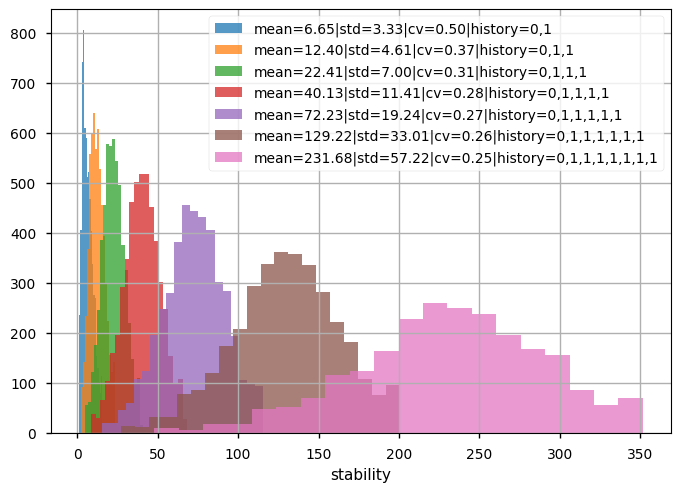

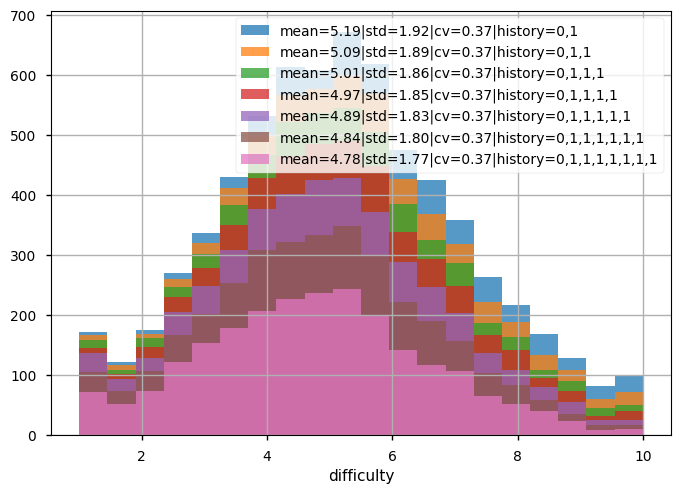

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')

r_history = '0,1'
while len(r_history.split(',')) < 9:
    s_mean = df_revlog[df_revlog['r_history'] == r_history]['stability'].mean()
    s_std = df_revlog[df_revlog['r_history'] == r_history]['stability'].std()
    s_cv = s_std / s_mean
    if pd.isna(s_cv):
        break
    plt.figure('stability')
    df_revlog[df_revlog['r_history'] == r_history]['stability'].hist(bins=20, alpha=0.75, label=f'mean={s_mean:.2f}|std={s_std:.2f}|cv={s_cv:.2f}|history={r_history}')
    plt.legend()
    plt.xlabel('stability')
    d_mean = df_revlog[df_revlog['r_history'] == r_history]['difficulty'].mean()
    d_std = df_revlog[df_revlog['r_history'] == r_history]['difficulty'].std()
    d_cv = d_std / d_mean
    plt.figure('difficulty')
    df_revlog[df_revlog['r_history'] == r_history]['difficulty'].hist(bins=20, alpha=0.75, label=f'mean={d_mean:.2f}|std={d_std:.2f}|cv={d_cv:.2f}|history={r_history}')
    plt.legend()
    plt.xlabel('difficulty')
    r_history += ',1'

